## Intro Time Series 

**Data Source:** [Weather history download Basel](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604)

**date:** 2020-05-12


## Prepare Notebook

In [1]:
# Main data packages. 
import numpy as np
import pandas as pd
# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## Read Data 

In [4]:
raw_df = pd.read_csv('../data/basel_weather.csv')

raw_df.head()

,timestamp,Basel Temperature [2 m elevation corrected],Basel Precipitation Total,Basel Wind Speed [10 m],Basel Wind Direction [10 m]
0,20080101T0200,-0.109471,0.0,0.000000,180.00000
1,20080101T0300,1.900529,0.0,2.397600,89.99999
2,20080101T0400,1.610529,0.0,0.799200,180.00000
3,20080101T0500,1.110529,0.0,0.842431,198.43495
4,20080101T0600,0.820529,0.0,2.527292,161.56505


## Format Data 

In [31]:
data_df = raw_df.copy()

data_df = data_df.rename(columns={
    'Basel Temperature [2 m elevation corrected]': 'temperature', 
    'Basel Precipitation Total': 'precipitation', 
    'Basel Wind Speed [10 m]': 'wind_speed', 
    'Basel Wind Direction [10 m]': 'wind_direction'
    }
)

data_df = data_df.assign(
    timestamp = lambda x: pd.to_datetime(x['timestamp']), 
    date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    hour = lambda x: x['timestamp'].dt.hour,
)

data_df.head()

,timestamp,temperature,precipitation,wind_speed,wind_direction,date,year,month,day,hour
0,2008-01-01 02:00:00,-0.109471,0.0,0.000000,180.00000,2008-01-01,2008,1,1,2
1,2008-01-01 03:00:00,1.900529,0.0,2.397600,89.99999,2008-01-01,2008,1,1,3
2,2008-01-01 04:00:00,1.610529,0.0,0.799200,180.00000,2008-01-01,2008,1,1,4
3,2008-01-01 05:00:00,1.110529,0.0,0.842431,198.43495,2008-01-01,2008,1,1,5
4,2008-01-01 06:00:00,0.820529,0.0,2.527292,161.56505,2008-01-01,2008,1,1,6


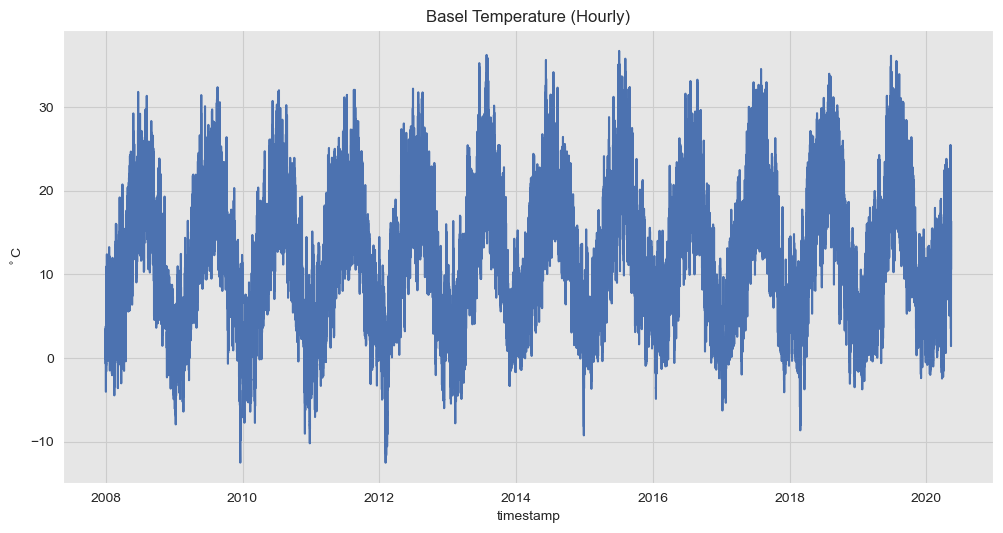

In [34]:
fig, ax = plt.subplots()
sns.lineplot(x='timestamp', y='temperature', data=data_df, ax=ax)
ax.set(title='Basel Temperature (Hourly)', ylabel=r'$^\circ$C');

In [62]:
daily_data_df = data_df.groupby(['date'], as_index=True).agg({'temperature': np.mean})

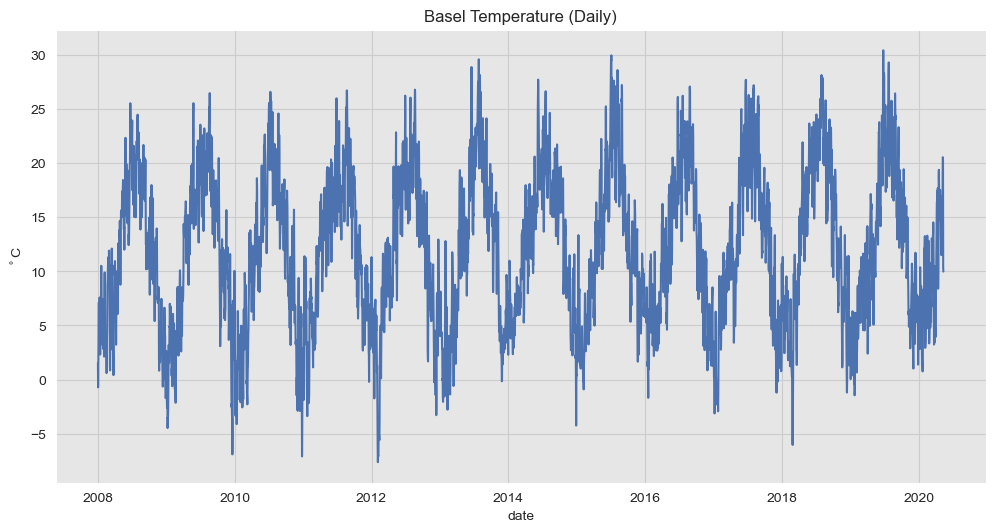

In [63]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='temperature', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Basel Temperature (Daily)', ylabel=r'$^\circ$C');

## Time Series Decomposition

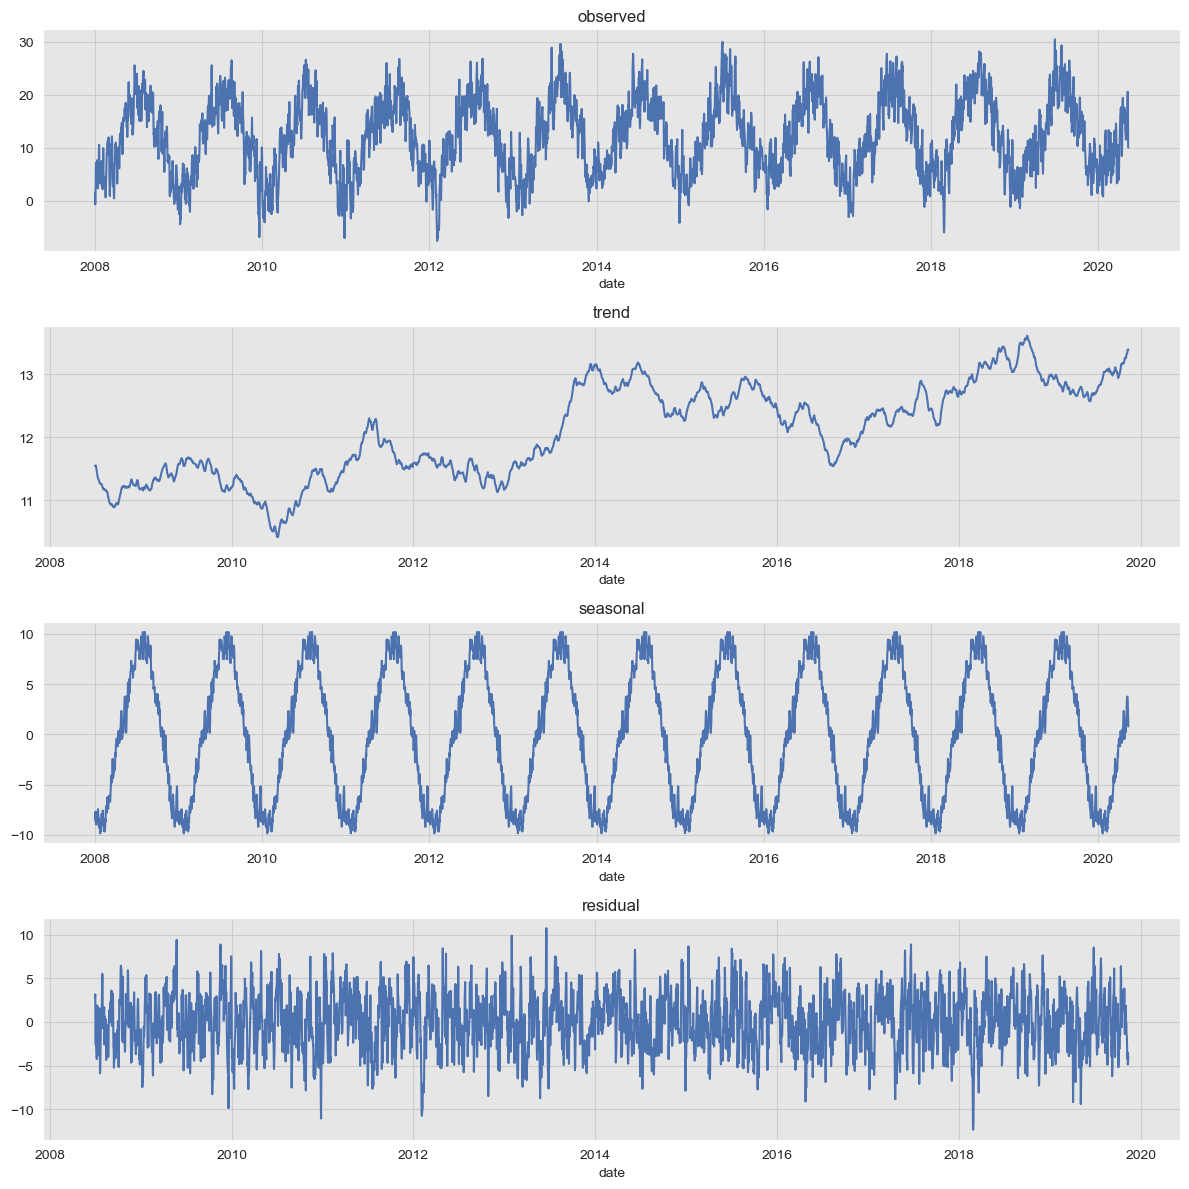

In [85]:
from statsmodels.tsa.seasonal import seasonal_decompose

seas_decomp_yearly = seasonal_decompose(x=daily_data_df, model='additive', period=365)

fig, ax = plt.subplots(4, 1, figsize=(12, 12))

seas_decomp_yearly.observed.plot(ax=ax[0])
ax[0].set(title='observed')
seas_decomp_yearly.trend.plot(ax=ax[1])
ax[1].set(title='trend')
seas_decomp_yearly.seasonal.plot(ax=ax[2])
ax[2].set(title='seasonal')
seas_decomp_yearly.resid.plot(ax=ax[3])
ax[3].set(title='residual')
plt.tight_layout()

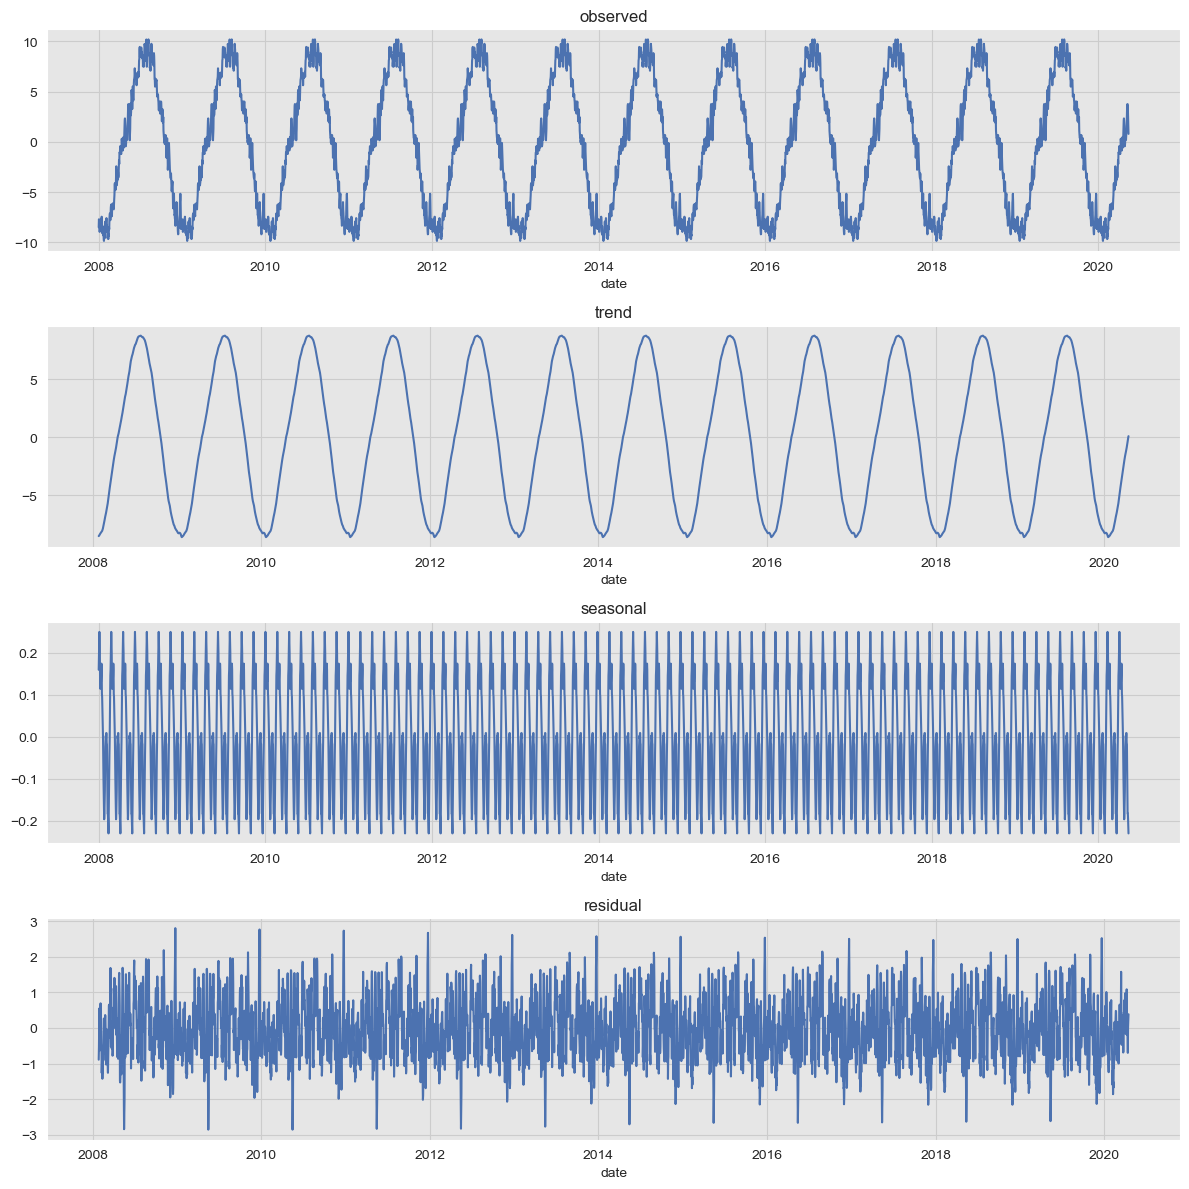

In [89]:
seas_decomp_monthly = seasonal_decompose(x=seas_decomp_yearly.seasonal, model='additive', period=52)

fig, ax = plt.subplots(4, 1, figsize=(12, 12))

seas_decomp_monthly.observed.plot(ax=ax[0])
ax[0].set(title='observed')
seas_decomp_monthly.trend.plot(ax=ax[1])
ax[1].set(title='trend')
seas_decomp_monthly.seasonal.plot(ax=ax[2])
ax[2].set(title='seasonal')
seas_decomp_monthly.resid.plot(ax=ax[3])
ax[3].set(title='residual')
plt.tight_layout()